In [1]:
protein = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
from disassembly.simulate_proteolysis import (
    simulate_proteolysis,
    enzyme_set,
    enzyme,
)
from disassembly.util import amino_acids

n_generate = 1000

k_enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
    ],
    [1],
    [1],
)

kr_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
    ],
    [1],
    [1],
)

viat_enzymes = enzyme_set(
    [
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1],
    [1],
)

krviat_enzymes = enzyme_set(
    [
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1],
    [1, 1],
)

random_enzymes = enzyme_set(
    [enzyme({aa: 1 / len(amino_acids) for aa in amino_acids.values()}, "random")],
    [1],
    [1],
)

In [2]:
generated_peptidomes = {"name": [], "peptidome": []}

names = ["k", "kr", "krviat", "viat", "random"]

i = 0
for enz, name in zip(
    [k_enzymes, kr_enzymes, krviat_enzymes, viat_enzymes, random_enzymes], names
):
    for i in range(10):
        generated_peptidome = simulate_proteolysis(
            protein,
            n_start=1,
            n_generate=n_generate,
            endo_or_exo_probability=[0.9, 0.1],
            enzymes=enz,
            graph=False,
            accept_condition=False,
        )
        generated_peptidomes["name"].append(f"{name}_{i}")
        generated_peptidomes["peptidome"].append(generated_peptidome)

 998 / 1000 (561)
161 unique peptides. 1001 total
 999 / 1000 (557)
154 unique peptides. 1002 total
 999 / 1000 (600)
148 unique peptides. 1002 total
 999 / 1000 (546)
153 unique peptides. 1002 total
 999 / 1000 (547)
164 unique peptides. 1001 total
 999 / 1000 (542)
160 unique peptides. 1002 total
 999 / 1000 (572)
142 unique peptides. 1001 total
 999 / 1000 (543)
169 unique peptides. 1002 total
 998 / 1000 (526)
155 unique peptides. 1001 total
 998 / 1000 (545)
158 unique peptides. 1002 total
 997 / 1000 (511)
213 unique peptides. 1001 total
 999 / 1000 (480)
219 unique peptides. 1002 total
 999 / 1000 (517)
225 unique peptides. 1002 total
 999 / 1000 (478)
227 unique peptides. 1003 total
 998 / 1000 (524)
184 unique peptides. 1001 total
 997 / 1000 (498)
222 unique peptides. 1001 total
 999 / 1000 (491)
220 unique peptides. 1002 total
 999 / 1000 (501)
248 unique peptides. 1001 total
 999 / 1000 (526)
216 unique peptides. 1002 total
 998 / 1000 (513)
205 unique peptides. 1001 total


In [3]:
from disassembly.util import KL, normalize_dict


def compare(P, generated):
    P = normalize_dict(P)
    generated = normalize_dict(generated)
    P_vec = []
    generated_vec = []
    for key in P.keys():
        P_vec.append(P[key])
        if key in generated.keys():
            generated_vec.append(generated[key])
        else:
            generated_vec.append(0)
    for key in generated.keys():
        if key not in P.keys():
            P_vec.append(0)
            generated_vec.append(generated[key])
    return P_vec, generated_vec


comparisons = {}
for i in range(len(generated_peptidomes["peptidome"])):
    name_comp_1 = generated_peptidomes["name"][i]
    peptidome_comp_1 = generated_peptidomes["peptidome"][i]
    comparisons[name_comp_1] = {}
    for j in range(len(generated_peptidomes["peptidome"])):
        name_comp_2 = generated_peptidomes["name"][j]
        peptidome_comp_2 = generated_peptidomes["peptidome"][j]
        p, q = compare(peptidome_comp_1, peptidome_comp_2)
        err = KL(p, q) + KL(q, p)
        comparisons[name_comp_1][name_comp_2] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


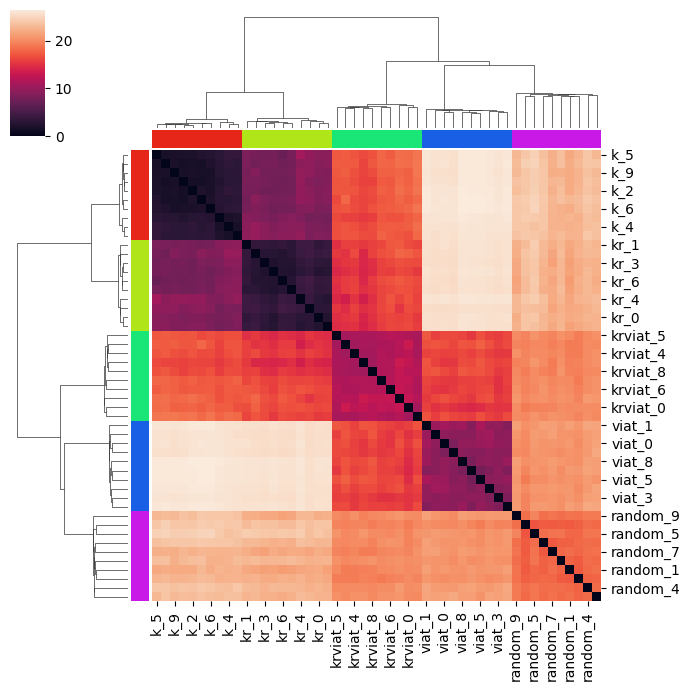

In [4]:
import seaborn as sns

lut = dict(zip(names, sns.hls_palette(len(names), l=0.5, s=0.8)))

lst = []
for i, n in enumerate(names):
    lst += [f"{n}"] * 10

row_colors = pd.DataFrame(lst)[0].map(lut)


sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)

In [5]:
from disassembly.util import amino_acids

# initialize

exo = 0.25
parameters = {
    "endo": {aa: 1 / len(amino_acids.values()) for aa in amino_acids.values()},
    "exo": exo,
}  # endo is dict of aa at p1

In [6]:
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme


# Say we want to estimate parameters for K enzyme.
enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1,0,0],  # abundances
)


true_dict, sequence_graph = simulate_proteolysis(
    protein,
    n_start=1,
    n_generate=n_generate,
    endo_or_exo_probability=[0.9, 0.1],
    enzymes=enzymes,
    graph=True,
    accept_condition=False,
)

 997 / 1000 (534)
159 unique peptides. 1001 total


In [7]:
from disassembly.util import normalize_dict


def generate_guess(parameters, protein):
    """
    Generates a guess from parameters
    """
    for aa in parameters["endo"]:
        parameters["endo"][aa] = max(0, parameters["endo"][aa])
    parameters["exo"] = max(0, parameters["exo"])
    parameters["endo"] = normalize_dict(parameters["endo"])
    parameter_enzyme = enzyme_set([enzyme(parameters["endo"], "")], [1], [1])
    guess = simulate_proteolysis(
        protein,
        parameter_enzyme,
        n_start=1,
        n_generate=n_generate,
        endo_or_exo_probability=[1 - parameters["exo"], parameters["exo"]],
        verbose=False,
        accept_condition=False,
        graph=False,
    )
    return guess

In [8]:
import random

lr_endo = 0.5
lr_exo = 0.05

best_losses = []
all_losses = []

starting_guess = generate_guess(parameters, protein)
p, q = compare(true_dict, starting_guess)


def update_parameter(parameters, aa, e, verbose=False):
    parameters["endo"][aa] += e
    new_guess = generate_guess(parameters, protein)
    p, q = compare(true_dict, new_guess)
    new_loss = KL(p, q) + KL(q, p)
    if verbose:
        print(f"\t{aa}: {new_loss:.2f} | {loss_to_beat:.2f}")
    return parameters, new_loss


loss_to_beat = KL(p, q) + KL(q, p)  # loss for current set of parameters

for i in range(3):
    print(f"Iteration: {i}")

    for aa in parameters["endo"].keys():
        new_parameters, new_loss = update_parameter(
            parameters, aa, lr_endo, verbose=True
        )
        while new_loss < loss_to_beat:
            diff = loss_to_beat - new_loss
            if diff > 0:
                print(f"{aa} better!")

                loss_to_beat = new_loss
                best_losses.append(new_loss)
                parameters, new_loss = update_parameter(
                    parameters, aa, lr_endo * diff, verbose=True
                )
        parameters["endo"][aa] -= lr_endo  # this resets the initial guess

for i in range(20):
    exo_diff = lr_exo * random.choice([-1, 1])
    parameters["exo"] = parameters["exo"] + exo_diff
    new_guess = generate_guess(parameters, protein)
    p, q = compare(true_dict, new_guess)
    new_loss = KL(p, q) + KL(q, p)
    all_losses.append(new_loss)
    if new_loss > loss_to_beat:
        parameters["exo"] -= exo_diff
    else:
        loss_to_beat = new_loss
        best_losses.append(new_loss)

    print(f" exo: {new_loss:.2f} | {loss_to_beat:.2f}")

Iteration: 0
	V: 23.92 | 22.57
	I: 24.11 | 22.57
	L: 24.43 | 22.57
	E: 24.60 | 22.57
	Q: 22.60 | 22.57
	D: 24.42 | 22.57
	N: 24.85 | 22.57
	H: 24.34 | 22.57
	W: 23.22 | 22.57
	F: 25.21 | 22.57
	Y: 22.93 | 22.57
	R: 24.42 | 22.57
	K: 10.27 | 22.57
K better!
	K: 5.31 | 10.27
K better!
	K: 4.56 | 5.31
K better!
	K: 2.56 | 4.56
K better!
	K: 3.70 | 2.56
	S: 10.68 | 2.56
	T: 12.71 | 2.56
	M: 5.98 | 2.56
	A: 14.81 | 2.56
	G: 15.35 | 2.56
	P: 12.56 | 2.56
	C: 8.73 | 2.56
Iteration: 1
	V: 13.62 | 2.56
	I: 4.57 | 2.56
	L: 15.46 | 2.56
	E: 10.79 | 2.56
	Q: 6.78 | 2.56
	D: 14.12 | 2.56
	N: 12.29 | 2.56
	H: 13.96 | 2.56
	W: 4.78 | 2.56
	F: 13.35 | 2.56
	Y: 8.77 | 2.56
	R: 10.05 | 2.56
	K: 3.98 | 2.56
	S: 10.32 | 2.56
	T: 13.29 | 2.56
	M: 6.44 | 2.56
	A: 17.92 | 2.56
	G: 14.75 | 2.56
	P: 11.64 | 2.56
	C: 8.35 | 2.56
Iteration: 2
	V: 17.26 | 2.56
	I: 4.91 | 2.56
	L: 18.74 | 2.56
	E: 12.61 | 2.56
	Q: 7.28 | 2.56
	D: 11.08 | 2.56
	N: 10.66 | 2.56
	H: 13.05 | 2.56
	W: 6.62 | 2.56
	F: 12.01 | 2.56
	Y: 9

0.25


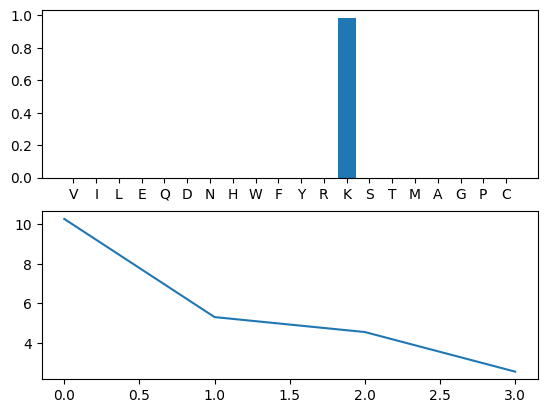

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].bar(parameters["endo"].keys(), parameters["endo"].values())
axs[1].plot(best_losses)
print(parameters["exo"])

## Turn the parameters into weights

 99 / 100 | 1.40, kl: 0.12, reg: 1.28  | nz: 1722 | 

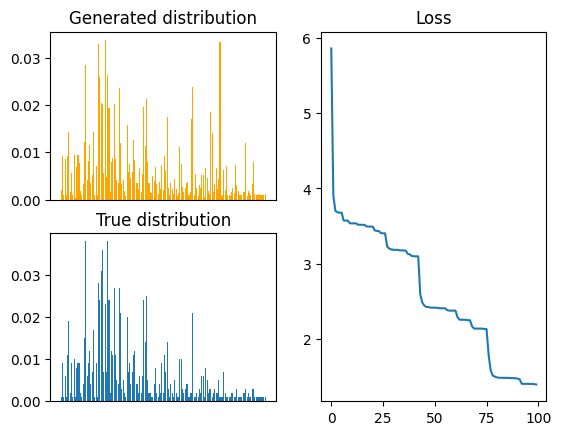

In [10]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

wegd = WeightEstimatorGD(lr=0.1, n_iterations=100, lam=0.1)

G = wegd.run(true_dict, verbose=True, parameters=parameters)
generated = wegd.generated
losses = wegd.losses
weights = wegd.weights

fig, axs = plt.subplot_mosaic(
    [["generated", "loss"], ["true", "loss"]], width_ratios=[2, 2]
)


axs["true"].bar(
    true_dict.keys(), [v / sum(true_dict.values()) for v in true_dict.values()]
)
axs["generated"].bar(
    generated[len(generated.keys()) - 1].keys(),
    generated[len(generated.keys()) - 1].values(),
    color="orange",
)
axs["loss"].plot(losses)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["loss"].set_title("Loss")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

0.5497108653748605

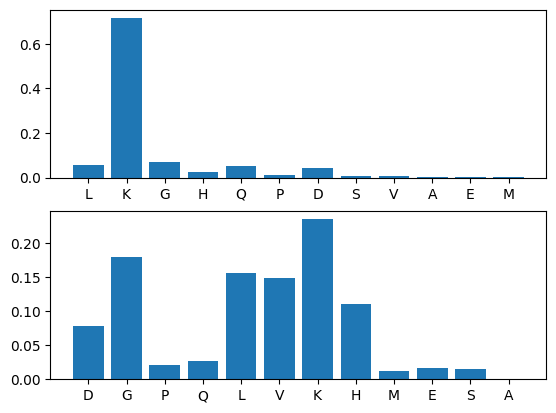

In [11]:
from disassembly.cut_site import get_p1

p1, p1_exo, exo, endo = get_p1(G, 5000)
fig, axs = plt.subplots(2, 1)
axs[0].bar(p1.keys(), height=p1.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
endo / (exo + endo)

0.7357400722021661

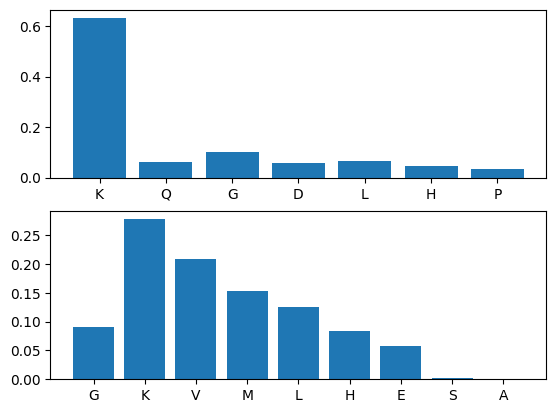

In [12]:

p1, p1_exo, exo, endo = get_p1(sequence_graph, 5000)
fig, axs = plt.subplots(2, 1)
axs[0].bar(p1.keys(), height=p1.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
endo / (exo + endo)

In [13]:
from disassembly.disassembly import get_disassembly_indexes_mc
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes_mc(sequence_graph, N_particles=10000)
get_disassembly(true_dict, real_disassembly_indexes)


 Averaged DI: 2.97


31.413735277072536

In [14]:
mc_di = get_disassembly_indexes_mc(G, 10000)
get_disassembly(true_dict, mc_di)


 Averaged DI: 3.42


66.25465675222311

Text(0.5, 0.98, 'Disassembly indexes')

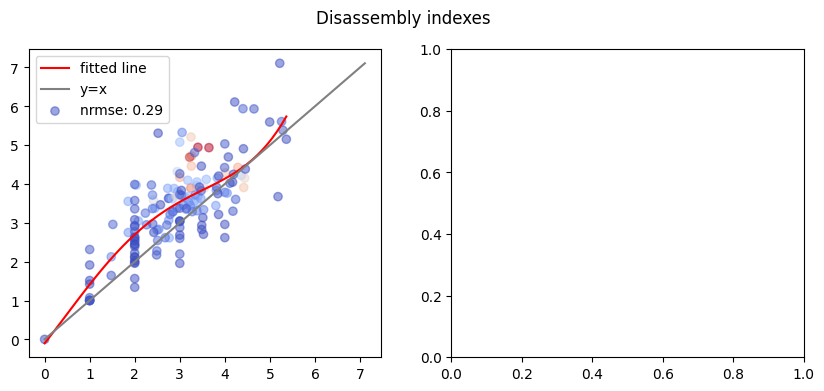

In [15]:
from scipy.stats import linregress
import numpy as np

# fig, axs = plt.subplots(1,3, figsize=(12,4))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
trues = []
ys_e = []
ys_mc = []
c = []


def get_nrmse(true, observed):
    true = np.array(true)
    observed = np.array(observed)
    rmse = np.sqrt(np.mean((true - observed)**2))
    nrmse = rmse / np.mean(true)
    return nrmse           


for key in true_dict.keys():
    if str(np.mean(mc_di[key])) == "nan":
        print(key)
        continue
    trues.append((real_disassembly_indexes[key]))
    # ys_e.append((estimated_disassembly_indexes[key]))
    ys_mc.append(mc_di[key])
    c.append(true_dict[key])
a = 0
# for xs, ys in [(trues, ys_e), (trues, ys_mc), (ys_e, ys_mc)]:
for xs, ys in [(trues, ys_mc)]:
    regress = np.polyfit(xs, ys, 4)
    nrmse = get_nrmse(xs, ys)
    axs[a].plot(
        np.linspace(0, max(xs)),
        regress[0] * np.linspace(0, max(xs))**4 +
         regress[1] * np.linspace(0, max(xs))**3 +
          regress[2] * np.linspace(0, max(xs))**2 +
           regress[3] * np.linspace(0, max(xs)) +
            regress[4],
        label="fitted line",
        color="red"
    )
    axs[a].plot(
        np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x"
    )
    axs[a].scatter(
        xs, ys, label=f"nrmse: {nrmse:.2f}", c=c, cmap="coolwarm", alpha=0.5
    )
    axs[a].legend()
    a += 1

plt.suptitle("Disassembly indexes")